In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import disk
%matplotlib inline

In [3]:
def adaptive_thresh(input_img):

    h, w = input_img.shape

    S = int(w/8)
    s2 = int(S/2)
    T = 10.0

    #integral img
    int_img = np.zeros_like(input_img, dtype=np.uint32)
    for col in range(w):
        for row in range(h):
            int_img[row,col] = input_img[0:row,0:col].sum()

    #output img
    out_img = np.zeros_like(input_img)    

    for col in range(w):
        for row in range(h):
            #SxS region
            y0 = max(row-s2, 0)
            y1 = min(row+s2, h-1)
            x0 = max(col-s2, 0)
            x1 = min(col+s2, w-1)

            count = (y1-y0)*(x1-x0)
            #print(x0,y0,x1,y1)
            sum_ = int_img[y1, x1]-int_img[y0, x1]-int_img[y1, x0]+int_img[y0, x0]

            if input_img[row, col]*count < sum_*(100.-T)/100.:
                out_img[row,col] = 0
            else:
                out_img[row,col] = 255

    return out_img


def faster_bradley_threshold(image, threshold=90, window_r=45):
    percentage = threshold / 100.
    window_diam = 2*window_r + 1
    # convert image to numpy array of grayscale values
    img = np.array(image).astype(np.float) # float for mean precision 
    # matrix of local means with scipy
    means = ndimage.uniform_filter(img, window_diam)
    # result: 0 for entry less than percentage*mean, 255 otherwise 
    height, width = img.shape[:2]
    result = np.zeros((height,width), np.uint8)   # initially all 0
    result[img >= percentage * means] = 255 
    return np.array(result)


In [4]:
def get_shading(rim,mask):
    im=rim

    im=cv2.copyMakeBorder(rim, top=100, bottom=100, left=100, right=100, borderType= cv2.BORDER_CONSTANT, value=255)
    mask=cv2.copyMakeBorder(mask, top=100, bottom=100, left=100, right=100, borderType= cv2.BORDER_CONSTANT, value=255)
    mask=mask/255
    shading=np.zeros(im.shape)
    for i in range(len(im)):
        #print(i)
        for j in range(len(im[i])):
            if mask[i][j]>0:
                shading[i][j]=im[i][j]
            else:
                dx=3
                dy=3
                while np.count_nonzero(mask[i-dx:i+dx,j-dy:j+dy])<25:
                    dx+=2
                    dy+=1
                curr=0.0
                tot=0.0
                for it1 in range(max(i-dx,0),min(i+dx,len(mask))):
                    for it2 in range(max(j-dy,0),min(j+dy,len(mask[0]))):
                        if mask[it1][it2]>0:
                            curr+=im[it1][it2]
                            tot+=1
                shading[i][j]=curr/tot



    return shading[100:-100,100:-100]



def get_reflectance(im,shading):
	reflectance=np.zeros(im.shape)
	for i in range(len(im)):
		for j in range(len(im[i])):
	
			reflectance[i][j]=((im[i][j]*1.0)/shading[i][j])
	#reflectance=reflectance[30:-30,30:-30]

	return reflectance

In [30]:
rim=cv2.imread('reflectance.png',0)
mask=cv2.imread('0mask.png',0)
c=0
for i in range(len(mask)):
    for j in range(len(mask[i])):
        if mask[i][j]>0:
            mask[i][j]=255
        else:
            mask[i][j]=0
            c+=1
print(c)



130850


In [32]:
shading=get_shading(rim,mask)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

True

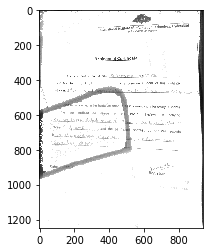

In [37]:
nshading = (255*(shading-np.min(shading)))/(np.max(shading)-np.min(shading))
ref=get_reflectance(rim,shading)
plt.imshow(ref,cmap='gray')
cv2.imwrite('1.png',ref)

In [5]:
rim=cv2.imread('./ACCV-Dataset/RealWorld/032.png',0)
rim=np.array(rim,dtype='float32')
circle = disk(5)
#rim=cv2.resize(rim,None,fx=0.2,fy=0.2)
for i in range(10):
    print("Iteration",i)
    #mask=cv2.adaptiveThreshold(rim, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,41,20) 
    mask=adaptive_thresh(rim)
    #mask=cv2.dilate(mask,circle,iterations = 1)
    print("Thresholding done")
    n3=str(i)+'mask.png'
    cv2.imwrite(n3,mask)

    shading=get_shading(rim,mask)
    print("shading done")
    
    #plt.imshow(shading,cmap='gray')

    rim=get_reflectance(rim,shading)
    ms=np.max(rim)
    mi=np.min(rim)
    rim=255*(rim-np.min(rim))
    rim=rim/(ms-mi)
    n1=str(i)+'shading.png'
    n2=str(i)+'reflectance.png'
    cv2.imwrite(n1,shading)
    cv2.imwrite(n2,rim)

Iteration 0


/home/shyamgopal/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in uint_scalars


Thresholding done
shading done
Iteration 1
Thresholding done
shading done
Iteration 2
Thresholding done
shading done
Iteration 3
Thresholding done
shading done
Iteration 4
Thresholding done
shading done
Iteration 5
Thresholding done
shading done
Iteration 6
Thresholding done
shading done
Iteration 7
Thresholding done
shading done
Iteration 8
Thresholding done
shading done
Iteration 9
Thresholding done
shading done


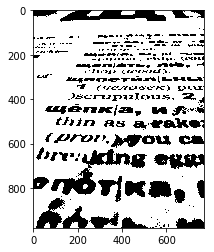

In [39]:
#rim=cv2.imread('reflectance.png',0)

plt.imshow(mask,cmap='gray')
nmask=cv2.dilate(mask,circle,iterations = 5)